# Teste para novo produto do Rei do Pitaco

O Rei do Pitaco é um jogo de habilidade que transmite ao usuário a sensação de ser um técnico de futebol de verdade, pois o objetivo é montar uma escalação a partir de jogadores reais, que baseado nas ações dentro da partida de futebol, o usuário acumula pontos.

Na minha opinião, um dos produtos mais interessantes do Rei do Pitaco é a liga "Dobro ou Nada".

Nesta liga, você aposta um valor fixo (R$ 5,00) e, caso você fique colocado nos top 50% melhores, você recebe R$ 10,00 e caso você esteja fora dos 50% melhores colocados, você perde o valor apostado.

Esta liga tem valor esperado igual a 0 já metade dos jogadores vai dobrar seu patrimônio e a outra metade vai perder o valor que apostou.

Minha proposta neste estudo é criar um novo produto em moldes parecidos mas que o site consiga ter ganho dos apostadores.

Objetivos

* Fazer com que o site tenha lucro sobre o investimento dos apostadores

* Permitir com que os apostadores joguem o quanto quiserem sem prejuízo para o site

* Ser atrativo para os apostadores

Linha de Raciocínio

* Simular centenas de jogadores apostando valores aleatórios

* Simular _x_% dos jogadores dobrando o patrimônio e 100-_x_% perdendo o que apostou, onde 50 > x > 0

* Calcular a rentabilidade e o risco para diferentes valores de _x_

In [39]:
import numpy as np
import pandas as pd
from scipy import stats
import random
import time
import matplotlib.pyplot as plt

Conforme nossa linha de raciocínio acima, vamos fazer simulações para diferentes valores de x, sendo x a proporção dos primeiros colocados que receberão prêmios.

Para cada valor de x, simularemos 10.000 rodadas, para reduzir o impacto da aleatoriedade no nosso experimento.

In [43]:
num_jogadores = 1000 #num de jogadores em cada rodada
medias = list()

for x in np.linspace(0, 1, 11):
    resultados = list()
    for i in range(10000):

        valores_apostados = np.round(np.random.uniform(1, 1000, num_jogadores), 2) #sorteando aleatoriamente os valores apostados
        caixa_final = np.sum(valores_apostados) #calculando a arrecadação da rodada

        #Embaralhando a lista para simular a colocação dos jogadores. 
        #Nesta parte estou assumindo que a pontuação de um jogador é independente do valor que ele aposta
        np.random.shuffle(valores_apostados)

        # Pegando os x% melhores jogadores e definindo-os como vencedores. Estes jogadores receberão o dobro do valor apostado.
        jogadores_vencedores = valores_apostados[0:int(len(valores_apostados)*x)]

        valor_pago = np.sum(jogadores_vencedores)*2 #calculando qual o valor pago final

        resultados.append((caixa_final-valor_pago)/caixa_final) #calculando o lucro da rodada
    
    medias.append(np.mean(resultados)) #pegando a média dos lucros das 10.000 rodadas




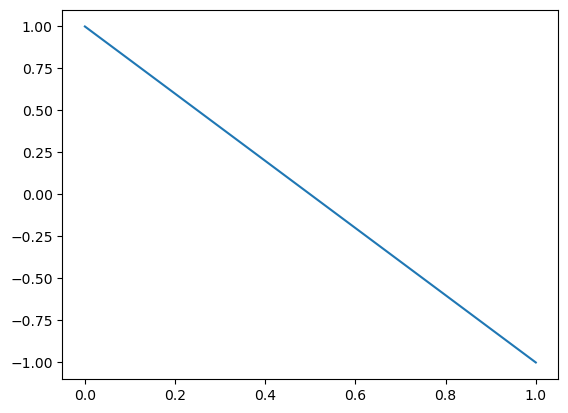

In [107]:
plt.plot(np.linspace(0, 1, 11), medias)
plt.show()

Como podemos ver pelo gráfico acima, o lucro obtido para diferentes valores de x segue uma tendência linear. Vamos descobrir a equação desta reta através de uma regressão linear simples.



In [44]:

y = medias
x = np.linspace(0, 1, 11)
stats.linregress(x, y)

LinregressResult(slope=-2.0000258433651883, intercept=1.0000458404395616, rvalue=-0.9999999824590161, pvalue=7.339344640615526e-35, stderr=0.00012486948798183796, intercept_stderr=7.387378533753521e-05)

Pelo resultado acima, podemos observar que nossa equação de reta é dada por

$
Y = 1 - 2x
$

Este resultado nos mostra, entre outras coisas, que, quando x = 0.5, como o produto atual do Rei do Pitaco, o lucro é igual a 0, conforme havíamos falado anteriormente.

Observando a equação, também podemos concluir que, se premiarmos mais de 50% dos participantes, teremos prejuízo no longo prazo mas por outro lado, se premiarmos menos que 50%, teremos lucro.

Cabe a área comercial avaliar qual a porcentagem ideal de premiados para que haja um equilíbrio entre lucratividade e atratividade para os apostadores, já que é esperado que poucas pessoas apostem se o número de premiados for baixo.

# Considerando diferentes probabilidades de estar na faixa de premiação

Podemos realizar o estudo em que não consideramos que a pontuação e o valor apostado sejam diferentes.
Um jogador que esteja em boa fase no _fantasy_ ou que esteja muito confiante pode apostar um valor maior do que quem está sempre perdendo.


Para tentar avaliar este efeito, vamos construir uma probabilidade de o jogador estar na faixa vencedora baseado no valor apostado através de uma função logística

Como no exemplo anterior, consideramos que o valor apostado deve estar no intervalo [1, 1000], vamos manter este intervalo e considerar que:
* Um jogador que apostar R$ 900,00 tem, aproximadamente, 72% de chance de estar na faixa vencedora
* Um jogador que apostar R$ 100,00 tem, aproximadamente, 28% de chance de estar na faixa vencedora

Desta forma, para encontrarmos os coeficientes da nossa reta, precisamos resolver o sistema de equações a seguir:


$
\\
\\
\\
\beta_{0} + \beta_{1} * 900 = \log{ \frac{1-0.72}{0.72}}\\
\beta_{0} + \beta_{1} * 100 = \log{ \frac{1-0.28}{0.28}}
\\
\\
\\
$


Resolvendo a equação, chegamos no valor de -1.1942 para $\beta_{0}$ e 0,0024 para $\beta_{1}$ e nossa curva fica:

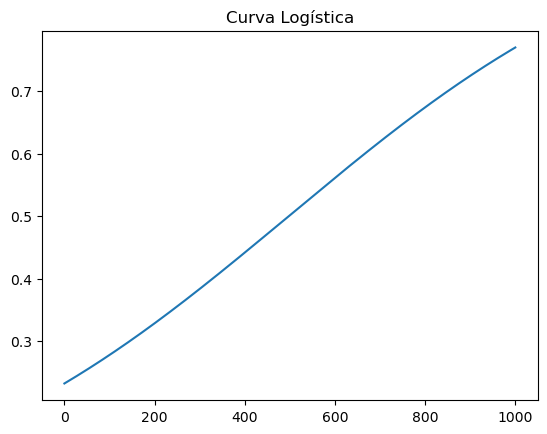

In [6]:
b0 = -1.1942
b1 = 0.0024

ar = np.linspace(0, 1000,1000)
plt.plot(ar, 1/(1+np.exp(-(b0 + b1*ar))))
plt.title("Curva Logística")
plt.show()

In [4]:
def aplica_logistica(x):
    return 1/(1+np.exp(-(b0 + b1*x)))

In [45]:
num_jogadores = 1000 #num de jogadores em cada rodada
medias = list()

for x in np.linspace(0, 1, 11):
    
    resultados = list()
    for i in range(5000):

        valores_apostados = np.round(np.random.uniform(1, 1000, num_jogadores), 2) #sorteando aleatoriamente os valores apostados
        caixa_final = np.sum(valores_apostados) #calculando a arrecadação da rodada

        probabilidades = [aplica_logistica(valor) for valor in valores_apostados] #definindo a probabilidade de cada jogador estar na área premiada de acordo com o valor apostado

        jogadores_vencedores = random.choices(valores_apostados, probabilidades, k = int(num_jogadores*x)) #usando o random.choices para escolher num_jogadore*x baseado nas probs definids

        valor_pago = np.sum(jogadores_vencedores)*2 #calculando qual o valor pago final

        resultados.append((caixa_final-valor_pago)/caixa_final) #calculando o lucro da rodada
    
    medias.append(np.mean(resultados)) #pegando a média dos lucros das 10.000 rodadas



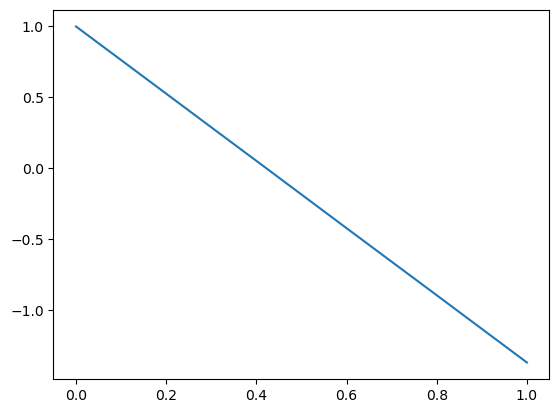

In [32]:
plt.plot(np.linspace(0, 1, 11), medias)
plt.show()

In [41]:
y = medias
x = np.linspace(0, 1, 11)
stats.linregress(x, y)

LinregressResult(slope=-2.371757089843497, intercept=0.999968472078556, rvalue=-0.999999943977197, pvalue=1.3647598472715537e-32, stderr=0.0002646344536555202, intercept_stderr=0.00015655985411830355)

Pelo resultado acima, podemos observar que nossa equação de reta é dada por

$
Y = 1 - 2.37x
$

Com esta equação, concluímos que, para a casa ter lucro dada a probabilidade que atribuímos de cada jogador estar na faixa vencedora, a proporção de jogadores vencedores deve ser maior que 42%


# Conclusão

Como podemos ver no caso em que a pontuação de um jogador não depende do valor apostado, o lucro do site é garantido quando menos de 50% dos jogadores são premiados.

Já quando atribuímos probabilidades baseadas no valor apostado, precisamos que menos de 42% dos jogadores sejam premiados para garantir o lucro do site.

Obviamente, a equação do lucro muda de acordo com a probabilidade de cada jogador estar na faixa premiada, portanto cabe à equipe de Análise de Dados e BI analisar se há uma relação entre o valor apostado e a pontuação e mensurar quão forte é esta relação para calibrar os parâmetros da função logística de um modo mais realista para definir qual tamanho da faixa de premiação.